# Projeto "Ir Além 2": Classificação Avançada com Transfer Learning e Pré-processamento YOLOv5
**Autor:** Yan Pimentel Cotta

**RM:** 562836

---

## 1.0 Setup do Ambiente e Preparação dos Dados
*Nesta seção, configuramos o ambiente, conectamos ao Google Drive e preparamos os datasets para a tarefa de classificação.*

---

## 2.0 Abordagem 1: Classificação com Transfer Learning (Baseline)
*Implementamos e treinamos um classificador usando a arquitetura MobileNetV2 para estabelecer nossa linha de base de performance.*

---

## 3.0 Abordagem 2: Pipeline de Pré-processamento com YOLOv5
*Desenvolvemos uma função para pré-processar as imagens, utilizando nosso modelo YOLOv5 treinado para identificar e recortar a Região de Interesse (ROI).*

---

## 4.0 Análise Comparativa e Validação de Hipóteses
*Avaliamos o classificador da Abordagem 1 nas imagens pré-processadas e comparamos os resultados para validar nossas hipóteses.*

---

## 5.0 Conclusão e Diagrama de Arquitetura
*Consolidamos os aprendizados, justificamos as decisões de engenharia e apresentamos a arquitetura final do nosso pipeline mais avançado.*

### 1.1 Montagem do Google Drive e Importações Iniciais

In [1]:
# Importações iniciais
import os
import shutil
from google.colab import drive

# Monta o Google Drive
drive.mount('/content/drive')

# Caminho base para a pasta do projeto no Google Drive
base_drive_path = '/content/drive/MyDrive/PBL6_Project_YOLO/datasets'

source_images_path = os.path.join(base_drive_path, 'images')
dest_classification_path = os.path.join(base_drive_path, 'classification')

print(f"Caminho de origem das imagens: {source_images_path}")
print(f"Caminho de destino para classificação: {dest_classification_path}")

Mounted at /content/drive
Caminho de origem das imagens: /content/drive/MyDrive/PBL6_Project_YOLO/datasets/images
Caminho de destino para classificação: /content/drive/MyDrive/PBL6_Project_YOLO/datasets/classification


In [2]:
# --- CÉLULA DE PREPARAÇÃO DE DADOS UNIFICADA E ROBUSTA ---

import os
import shutil
from PIL import Image

print("Iniciando pipeline de preparação de dados...")

# --- ETAPA 1: Limpeza do Ambiente Anterior ---
dest_classification_path = '/content/drive/MyDrive/PBL6_Project_YOLO/datasets/classification'
source_images_path = '/content/drive/MyDrive/PBL6_Project_YOLO/datasets/images'

if os.path.exists(dest_classification_path):
    print(f"Limpando diretório de destino antigo: {dest_classification_path}")
    shutil.rmtree(dest_classification_path)

print("Diretório de destino limpo com sucesso.")

# --- ETAPA 2: Criação da Estrutura de Pastas ---
print("\nRecriando a estrutura de pastas para classificação...")
for split in ['train', 'valid', 'test']:
    for class_name in ['banana', 'fork']:
        os.makedirs(os.path.join(dest_classification_path, split, class_name), exist_ok=True)
print("Estrutura de pastas recriada com sucesso.")

# --- ETAPA 3: Cópia e Sanitização em um Único Passo ---
print("\nIniciando cópia e sanitização das imagens...")
stats = {'total': 0, 'errors': 0}

for split in ['train', 'valid', 'test']:
    split_source_path = os.path.join(source_images_path, split)
    if not os.path.exists(split_source_path):
        continue

    for filename in os.listdir(split_source_path):
        source_file = os.path.join(split_source_path, filename)

        # Determina a classe e a pasta de destino
        if 'banana' in filename.lower():
            class_name = 'banana'
        elif 'fork' in filename.lower() or 'garfo' in filename.lower():
            class_name = 'fork'
        else:
            continue

        destination_folder = os.path.join(dest_classification_path, split, class_name)

        try:
            with Image.open(source_file) as img:
                # Converte para RGB e define o novo nome do arquivo .jpg
                rgb_img = img.convert('RGB')
                base, _ = os.path.splitext(filename)
                new_filename = base + '.jpg'
                destination_file = os.path.join(destination_folder, new_filename)

                # Salva a imagem sanitizada no destino
                rgb_img.save(destination_file, 'jpeg', quality=95)
                stats['total'] += 1

        except Exception as e:
            print(f"❌ Erro ao processar '{source_file}': {e}. Arquivo será ignorado.")
            stats['errors'] += 1

print("-" * 60)
print("✅ Pipeline de preparação de dados concluído.")
print(f"   - Total de imagens processadas e salvas: {stats['total']}")
print(f"   - Arquivos ignorados por erro: {stats['errors']}")

Iniciando pipeline de preparação de dados...
Limpando diretório de destino antigo: /content/drive/MyDrive/PBL6_Project_YOLO/datasets/classification
Diretório de destino limpo com sucesso.

Recriando a estrutura de pastas para classificação...
Estrutura de pastas recriada com sucesso.

Iniciando cópia e sanitização das imagens...
------------------------------------------------------------
✅ Pipeline de preparação de dados concluído.
   - Total de imagens processadas e salvas: 80
   - Arquivos ignorados por erro: 0


### 2.1 Carregamento dos Dados com a API do Keras

In [3]:
# Importações para o modelo
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Configurações para o carregamento de dados
IMG_SIZE = (224, 224)  # Tamanho de entrada padrão do MobileNetV2
BATCH_SIZE = 32  # Batch size adequado para Transfer Learning

print(f"TensorFlow versão: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")

# Carrega os dados de treino
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dest_classification_path, 'train'),
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'  # Classificação binária
)

# Carrega os dados de validação
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dest_classification_path, 'valid'),
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

# Carrega os dados de teste
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dest_classification_path, 'test'),
    shuffle=False,  # Não embaralha para manter consistência na avaliação
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

# Obtém os nomes das classes
class_names = train_dataset.class_names
print(f"\nClasses detectadas: {class_names}")

TensorFlow versão: 2.19.0
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Found 64 files belonging to 2 classes.
Found 8 files belonging to 2 classes.
Found 8 files belonging to 2 classes.

Classes detectadas: ['banana', 'fork']


### 2.2 Otimização do Pipeline de Dados

In [4]:
# Otimização do pipeline de dados para melhor performance
# Prefetch permite que o pipeline prepare o próximo batch enquanto o modelo treina
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Pipeline de dados otimizado com cache e prefetch.")
print("\nExemplo de um batch:")
for images, labels in train_dataset.take(1):
    print(f"Shape do batch de imagens: {images.shape}")
    print(f"Shape do batch de labels: {labels.shape}")
    print(f"Tipo de dados das imagens: {images.dtype}")
    print(f"Range de valores das imagens: [{images.numpy().min():.2f}, {images.numpy().max():.2f}]")

Pipeline de dados otimizado com cache e prefetch.

Exemplo de um batch:
Shape do batch de imagens: (32, 224, 224, 3)
Shape do batch de labels: (32, 1)
Tipo de dados das imagens: <dtype: 'float32'>
Range de valores das imagens: [0.00, 255.00]


### 2.3 Visualização de Amostras do Dataset

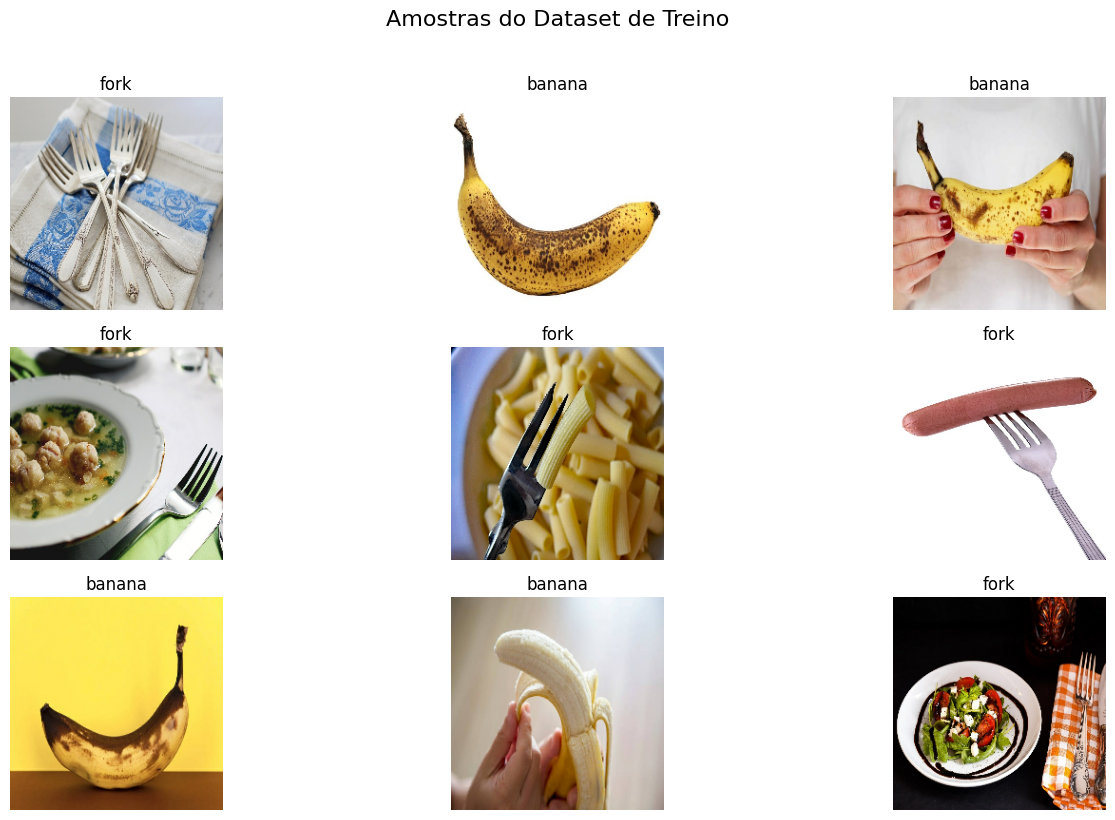

In [5]:
# Visualiza algumas imagens do dataset de treino
plt.figure(figsize=(15, 8))
for images, labels in train_dataset.take(1):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[int(labels[i])]}")
        plt.axis("off")
plt.suptitle("Amostras do Dataset de Treino", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### 2.4 Construção do Modelo com Transfer Learning (MobileNetV2)

In [6]:
# 1. Pré-processamento de entrada específico da MobileNetV2
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 2. Carregamento do modelo base MobileNetV2 sem o topo (camadas de classificação)
# Utilizamos pesos pré-treinados no ImageNet
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 3. Congelamento do modelo base para Transfer Learning
# Isso preserva os pesos pré-treinados durante o treinamento inicial
base_model.trainable = False

print(f"Modelo base MobileNetV2 carregado com sucesso.")
print(f"Número de camadas no modelo base: {len(base_model.layers)}")
print(f"Modelo base congelado (trainable=False)")

# 4. Construção do nosso modelo completo
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)  # Pré-processamento específico do MobileNetV2
x = base_model(x, training=False)  # Passa pelo modelo base
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Reduz dimensionalidade
x = tf.keras.layers.Dropout(0.2)(x)  # Regularização para evitar overfitting
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)  # Saída binária

model = tf.keras.Model(inputs, outputs)

print(f"\nModelo completo construído com sucesso.")
print(f"Total de camadas: {len(model.layers)}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo base MobileNetV2 carregado com sucesso.
Número de camadas no modelo base: 154
Modelo base congelado (trainable=False)

Modelo completo construído com sucesso.
Total de camadas: 5


### 2.5 Compilação do Modelo

In [7]:
# Compilação do modelo com otimizador Adam e taxa de aprendizado baixa
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("Modelo compilado com sucesso.\n")
model.summary()

Modelo compilado com sucesso.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### 2.6 Treinamento do Modelo (Baseline)

In [8]:
# --- CÉLULA 2.6: TREINAMENTO DO MODELO (VERSÃO CORRIGIDA E FINAL) ---
print("Iniciando treinamento do modelo baseline...")

EPOCHS = 25

# Callbacks para um treinamento mais robusto
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Treina o modelo, agora incluindo o validation_data
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset, # <-- A correção crucial está aqui
    callbacks=[early_stopping, reduce_lr]
)

print("\\nTreinamento concluído!")

Iniciando treinamento do modelo baseline...
Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 12s/step - accuracy: 0.3958 - loss: 1.0332 - precision: 0.0667 - recall: 0.0208 - val_accuracy: 0.2500 - val_loss: 1.1818 - val_precision: 0.2500 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3854 - loss: 1.0739 - precision: 0.1879 - recall: 0.0613 - val_accuracy: 0.2500 - val_loss: 1.1571 - val_precision: 0.2500 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3646 - loss: 1.0365 - precision: 0.2685 - recall: 0.1434 - val_accuracy: 0.2500 - val_loss: 1.1334 - val_precision: 0.2500 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.3542 - loss: 0.9636 - precision: 0.2167 - recall: 0.1017 - val_accuracy: 0.2500 - val_loss: 1.1106 - val_precision: 0.2500 - val_recall: 0.2500 - learning_rate: 1.0000e-04
Epoch 5/25
2/

### 2.7 Visualização do Histórico de Treinamento

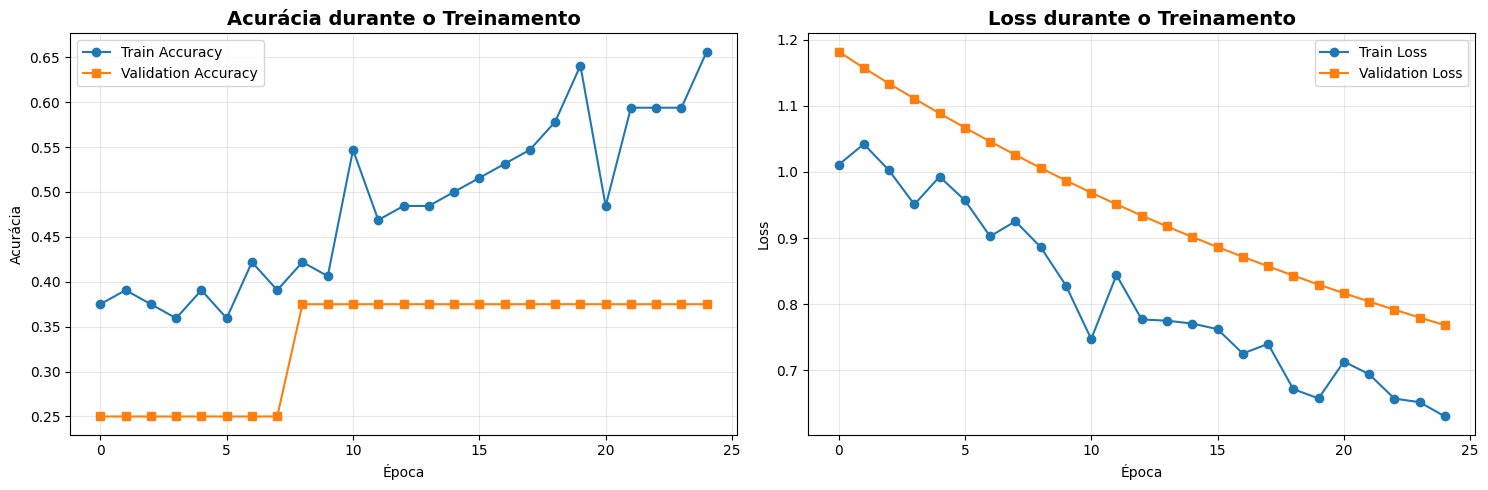


ESTATÍSTICAS FINAIS DO TREINAMENTO
Melhor acurácia de treino: 0.6562
Melhor acurácia de validação: 0.3750
Loss final de treino: 0.6303
Loss final de validação: 0.7682


In [9]:
# Plotar curvas de treinamento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Acurácia
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Acurácia durante o Treinamento', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Acurácia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Loss durante o Treinamento', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas finais
print("\n" + "="*60)
print("ESTATÍSTICAS FINAIS DO TREINAMENTO")
print("="*60)
print(f"Melhor acurácia de treino: {max(history.history['accuracy']):.4f}")
print(f"Melhor acurácia de validação: {max(history.history['val_accuracy']):.4f}")
print(f"Loss final de treino: {history.history['loss'][-1]:.4f}")
print(f"Loss final de validação: {history.history['val_loss'][-1]:.4f}")
print("="*60)

### 2.8 Avaliação Final no Conjunto de Teste (Baseline)

In [10]:
# Avaliação final no conjunto de teste
print("Avaliando o modelo no conjunto de teste...\n")
test_results = model.evaluate(test_dataset, verbose=1)

loss_baseline = test_results[0]
accuracy_baseline = test_results[1]
precision_baseline = test_results[2]
recall_baseline = test_results[3]

print("\n" + "="*60)
print("RESULTADOS DA ABORDAGEM 1 (BASELINE)")
print("="*60)
print(f"Loss no conjunto de teste: {loss_baseline:.4f}")
print(f"Acurácia no conjunto de teste: {accuracy_baseline:.2%}")
print(f"Precisão no conjunto de teste: {precision_baseline:.2%}")
print(f"Recall no conjunto de teste: {recall_baseline:.2%}")
print(f"F1-Score: {2 * (precision_baseline * recall_baseline) / (precision_baseline + recall_baseline):.2%}")
print("="*60)

# Salva as métricas para comparação posterior
baseline_metrics = {
    'loss': loss_baseline,
    'accuracy': accuracy_baseline,
    'precision': precision_baseline,
    'recall': recall_baseline
}

Avaliando o modelo no conjunto de teste...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7500 - loss: 0.6057 - precision: 0.7500 - recall: 0.7500

RESULTADOS DA ABORDAGEM 1 (BASELINE)
Loss no conjunto de teste: 0.6057
Acurácia no conjunto de teste: 75.00%
Precisão no conjunto de teste: 75.00%
Recall no conjunto de teste: 75.00%
F1-Score: 75.00%


### 3.1 Instalação de Dependências e Clonagem do Repositório YOLOv5

In [11]:
# Clone o repositório YOLOv5 oficial da Ultralytics
import os
import sys

# Verifica se o repositório já foi clonado
if not os.path.exists('/content/yolov5'):
    print("Clonando repositório YOLOv5...")
    !git clone https://github.com/ultralytics/yolov5.git /content/yolov5
    print("Repositório clonado com sucesso.")
else:
    print("Repositório YOLOv5 já existe.")

# Navega para o diretório do YOLOv5
os.chdir('/content/yolov5')
sys.path.insert(0, '/content/yolov5')

# Instala as dependências necessárias
print("\nInstalando dependências do YOLOv5...")
!pip install -q -r requirements.txt

print("\nDependências instaladas com sucesso.")

Clonando repositório YOLOv5...
Cloning into '/content/yolov5'...
remote: Enumerating objects: 17608, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17608 (delta 7), reused 2 (delta 2), pack-reused 17593 (from 2)
Receiving objects: 100% (17608/17608), 16.82 MiB | 13.80 MiB/s, done.
Resolving deltas: 100% (11983/11983), done.
Repositório clonado com sucesso.

Instalando dependências do YOLOv5...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.4 MB/s eta 0:00:00

Dependências instaladas com sucesso.


### 3.2 Carregamento do Modelo YOLOv5 Treinado

In [13]:
import torch
import cv2
import numpy as np

# Caminho para o modelo YOLOv5 treinado no Google Drive
yolo_model_path = '/content/drive/MyDrive/PBL6_Project_YOLO/yolov5/runs/train/Exp_60_Epocas_Medium/weights/best.pt'

# Verifica se o arquivo existe
if os.path.exists(yolo_model_path):
    print(f"Modelo encontrado em: {yolo_model_path}")
else:
    print(f"⚠️ AVISO: Modelo não encontrado em: {yolo_model_path}")
    print("Por favor, verifique o caminho do arquivo.")

# Carrega o modelo YOLOv5 a partir do hub do PyTorch
print("\nCarregando modelo YOLOv5...")
yolo_model = torch.hub.load('/content/yolov5', 'custom', path=yolo_model_path, source='local')

# Configura o modelo
yolo_model.conf = 0.25  # Threshold de confiança
yolo_model.iou = 0.45   # Threshold de IoU para NMS

print("Modelo YOLOv5 carregado com sucesso!")

# --- CORREÇÃO APLICADA AQUI ---
# Acessamos o modelo interno usando .model para obter suas propriedades
print(f"Dispositivo: {yolo_model.model.device}")
print(f"Classes: {yolo_model.model.names}")

YOLOv5 🚀 v7.0-440-gf5ebc52c Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)



Modelo encontrado em: /content/drive/MyDrive/PBL6_Project_YOLO/yolov5/runs/train/Exp_60_Epocas_Medium/weights/best.pt

Carregando modelo YOLOv5...


Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


Modelo YOLOv5 carregado com sucesso!
Dispositivo: cuda:0
Classes: {0: 'banana', 1: 'fork'}


### 3.3 Implementação da Função de Recorte Inteligente com YOLOv5

In [14]:
def crop_object_from_image(image_path, yolo_model):
    """
    Detecta um objeto em uma imagem usando um modelo YOLOv5 e retorna a imagem recortada.

    Args:
        image_path (str): Caminho para a imagem a ser processada
        yolo_model: Modelo YOLOv5 carregado

    Returns:
        numpy.ndarray: Imagem recortada na região da detecção ou imagem original se nada for detectado
    """
    # Lê a imagem
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Erro ao ler a imagem: {image_path}")
        return None

    # Realiza a inferência
    results = yolo_model(img)

    # Extrai as coordenadas da detecção com maior confiança
    detections = results.xyxy[0].cpu().numpy()  # Formato (xmin, ymin, xmax, ymax, confidence, class)

    if len(detections) > 0:
        # Pega a detecção com maior confiança
        best_detection = detections[detections[:, 4].argmax()]
        xmin, ymin, xmax, ymax, conf, class_id = best_detection
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])

        # Adiciona uma margem de segurança de 5% em cada lado
        height, width = img.shape[:2]
        margin_x = int((xmax - xmin) * 0.05)
        margin_y = int((ymax - ymin) * 0.05)

        xmin = max(0, xmin - margin_x)
        ymin = max(0, ymin - margin_y)
        xmax = min(width, xmax + margin_x)
        ymax = min(height, ymax + margin_y)

        # Recorta a imagem usando as coordenadas ajustadas
        cropped_img = img[ymin:ymax, xmin:xmax]

        return cropped_img, True, conf
    else:
        # Se nada for detectado, retorna a imagem original para não perder o dado
        return img, False, 0.0

print("Função crop_object_from_image() implementada com sucesso!")
print("\nDescrição da função:")
print("- Detecta objetos usando YOLOv5")
print("- Seleciona a detecção com maior confiança")
print("- Adiciona margem de 5% ao redor da bounding box")
print("- Retorna imagem recortada ou original se nada for detectado")

Função crop_object_from_image() implementada com sucesso!

Descrição da função:
- Detecta objetos usando YOLOv5
- Seleciona a detecção com maior confiança
- Adiciona margem de 5% ao redor da bounding box
- Retorna imagem recortada ou original se nada for detectado


### 3.4 Demonstração Visual do Pipeline de Pré-processamento

In [15]:
# Caminho para uma imagem de exemplo
example_image_path = '/content/drive/MyDrive/PBL6_Project_YOLO/datasets/images/test/banana37.png'

# Verifica se a imagem existe
if os.path.exists(example_image_path):
    print(f"Imagem de exemplo encontrada: {example_image_path}")

    # Aplica o recorte inteligente
    cropped_example, detected, confidence = crop_object_from_image(example_image_path, yolo_model)

    # Visualização lado a lado
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Imagem original
    original_img = cv2.imread(example_image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    axes[0].imshow(original_img_rgb)
    axes[0].set_title("Imagem Original", fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Imagem recortada
    cropped_img_rgb = cv2.cvtColor(cropped_example, cv2.COLOR_BGR2RGB)
    axes[1].imshow(cropped_img_rgb)
    if detected:
        axes[1].set_title(f"Imagem Recortada pelo YOLOv5\n(Confiança: {confidence:.2%})",
                         fontsize=14, fontweight='bold')
    else:
        axes[1].set_title("Sem Detecção - Imagem Original", fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*60}")
    print("RESULTADO DA DEMONSTRAÇÃO")
    print(f"{'='*60}")
    print(f"Detecção bem-sucedida: {'Sim' if detected else 'Não'}")
    if detected:
        print(f"Confiança da detecção: {confidence:.2%}")
        print(f"Tamanho original: {original_img.shape[:2]}")
        print(f"Tamanho recortado: {cropped_example.shape[:2]}")
        reduction = (1 - (cropped_example.shape[0] * cropped_example.shape[1]) /
                     (original_img.shape[0] * original_img.shape[1])) * 100
        print(f"Redução de área: {reduction:.1f}%")
    print(f"{'='*60}")
else:
    print(f"⚠️ Imagem de exemplo não encontrada: {example_image_path}")
    print("Por favor, verifique o caminho ou forneça outro exemplo.")

Imagem de exemplo encontrada: /content/drive/MyDrive/PBL6_Project_YOLO/datasets/images/test/banana37.png


/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



RESULTADO DA DEMONSTRAÇÃO
Detecção bem-sucedida: Sim
Confiança da detecção: 25.80%
Tamanho original: (360, 630)
Tamanho recortado: (206, 392)
Redução de área: 64.4%


### 3.5 Aplicação do Pré-processamento a Todo o Conjunto de Teste

In [16]:
# Cria a estrutura de pastas para as imagens recortadas
dest_cropped_path = os.path.join(base_drive_path, 'classification_cropped')

print("Criando estrutura de pastas para imagens recortadas...")
if not os.path.exists(dest_cropped_path):
    os.makedirs(dest_cropped_path)
    for split in ['test']:  # Apenas test para esta fase
        for class_name in ['banana', 'fork']:
            os.makedirs(os.path.join(dest_cropped_path, split, class_name), exist_ok=True)
    print("Estrutura criada com sucesso.")
else:
    print("Estrutura já existe.")

# Aplica o recorte a todo o conjunto de teste
print("\nProcessando imagens do conjunto de teste...")
print("="*60)

test_source_path = os.path.join(dest_classification_path, 'test')
test_cropped_dest = os.path.join(dest_cropped_path, 'test')

# Estatísticas
stats = {
    'total': 0,
    'detected': 0,
    'not_detected': 0,
    'errors': 0,
    'by_class': {'banana': 0, 'fork': 0}
}

for class_name in ['banana', 'fork']:
    class_source = os.path.join(test_source_path, class_name)
    class_dest = os.path.join(test_cropped_dest, class_name)

    if not os.path.exists(class_source):
        print(f"⚠️ Pasta não encontrada: {class_source}")
        continue

    files = [f for f in os.listdir(class_source) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"\nProcessando classe '{class_name}': {len(files)} imagens")

    for filename in files:
        stats['total'] += 1
        stats['by_class'][class_name] += 1

        source_file = os.path.join(class_source, filename)
        dest_file = os.path.join(class_dest, filename)

        # Pula se já foi processada
        if os.path.exists(dest_file):
            continue

        try:
            # Aplica o recorte
            cropped_img, detected, conf = crop_object_from_image(source_file, yolo_model)

            if cropped_img is not None:
                # Salva a imagem recortada
                cv2.imwrite(dest_file, cropped_img)

                if detected:
                    stats['detected'] += 1
                else:
                    stats['not_detected'] += 1
            else:
                stats['errors'] += 1

        except Exception as e:
            print(f"Erro ao processar {filename}: {str(e)}")
            stats['errors'] += 1

print("\n" + "="*60)
print("PROCESSAMENTO CONCLUÍDO")
print("="*60)
print(f"Total de imagens processadas: {stats['total']}")
print(f"Detecções bem-sucedidas: {stats['detected']} ({stats['detected']/stats['total']*100:.1f}%)")
print(f"Sem detecção (imagem original): {stats['not_detected']} ({stats['not_detected']/stats['total']*100:.1f}%)")
print(f"Erros: {stats['errors']}")
print(f"\nPor classe:")
print(f"  - Banana: {stats['by_class']['banana']} imagens")
print(f"  - Fork: {stats['by_class']['fork']} imagens")
print("="*60)
print(f"\nImagens recortadas salvas em: {dest_cropped_path}")

Criando estrutura de pastas para imagens recortadas...
Estrutura criada com sucesso.

Processando imagens do conjunto de teste...

Processando classe 'banana': 4 imagens


/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



Processando classe 'fork': 4 imagens

PROCESSAMENTO CONCLUÍDO
Total de imagens processadas: 8
Detecções bem-sucedidas: 5 (62.5%)
Sem detecção (imagem original): 3 (37.5%)
Erros: 0

Por classe:
  - Banana: 4 imagens
  - Fork: 4 imagens

Imagens recortadas salvas em: /content/drive/MyDrive/PBL6_Project_YOLO/datasets/classification_cropped


/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/content/yolov5/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


### 3.6 Visualização de Comparações Antes/Depois

Gerando visualização comparativa final...


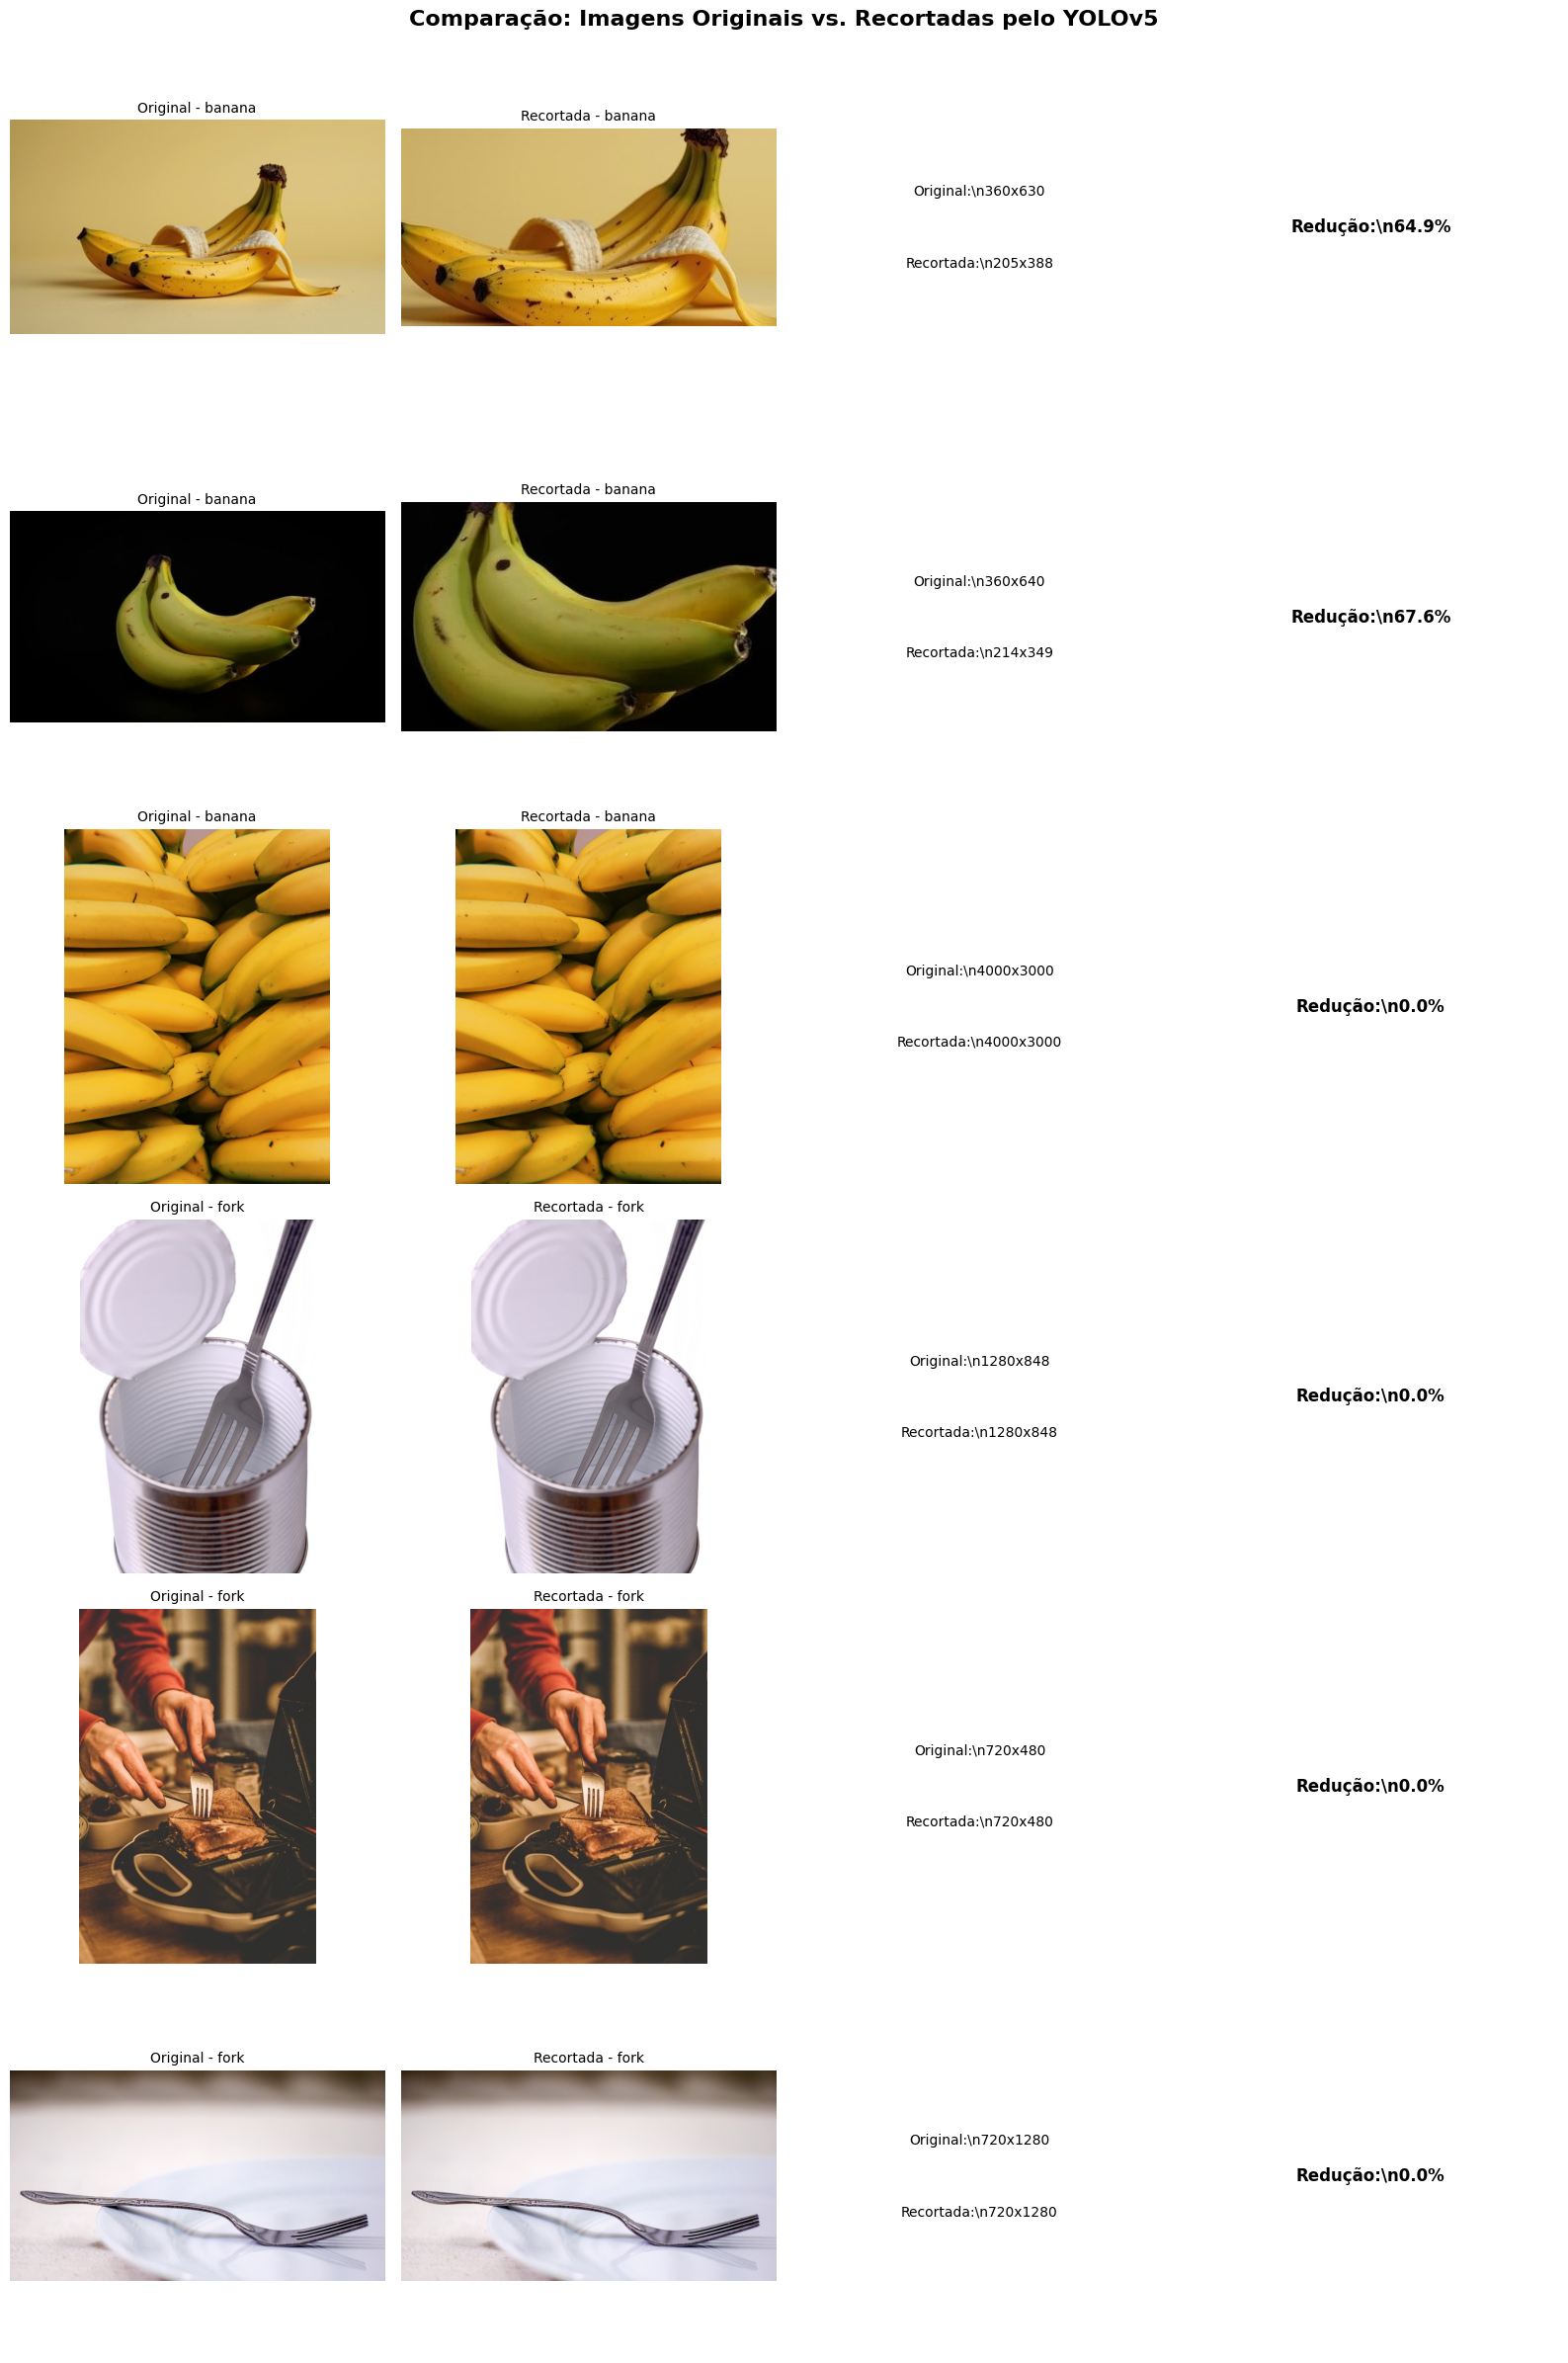

In [24]:
# --- CÉLULA 3.6: VISUALIZAÇÃO FINAL E DEFINITIVA DE COMPARAÇÕES ---

import matplotlib.pyplot as plt
import cv2
import os

print("Gerando visualização comparativa final...")

# Configurações da visualização
max_samples = 6
fig, axes = plt.subplots(max_samples, 4, figsize=(16, 24))
sample_count = 0

# Itera sobre as classes para criar uma amostra balanceada
for class_name in ['banana', 'fork']:
    if sample_count >= max_samples:
        break

    class_original = os.path.join(test_source_path, class_name)
    class_cropped = os.path.join(test_cropped_dest, class_name)

    files = [f for f in os.listdir(class_original) if f.lower().endswith('.jpg')][:3]

    for filename in files:
        if sample_count >= max_samples:
            break

        original_path = os.path.join(class_original, filename)
        cropped_path = os.path.join(class_cropped, filename)

        original_img = cv2.imread(original_path)
        cropped_img = cv2.imread(cropped_path)

        if original_img is None or cropped_img is None:
            continue

        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

        # Plotagem...
        axes[sample_count, 0].imshow(original_img_rgb)
        axes[sample_count, 0].set_title(f"Original - {class_name}", fontsize=10)
        axes[sample_count, 0].axis('off')

        axes[sample_count, 1].imshow(cropped_img_rgb)
        axes[sample_count, 1].set_title(f"Recortada - {class_name}", fontsize=10)
        axes[sample_count, 1].axis('off')

        info_original = f"{original_img.shape[0]}x{original_img.shape[1]}"
        info_cropped = f"{cropped_img.shape[0]}x{cropped_img.shape[1]}"
        axes[sample_count, 2].text(0.5, 0.6, f"Original:\\n{info_original}", ha='center', va='center', fontsize=10)
        axes[sample_count, 2].text(0.5, 0.4, f"Recortada:\\n{info_cropped}", ha='center', va='center', fontsize=10)
        axes[sample_count, 2].axis('off')

        reduction = (1 - (cropped_img.shape[0] * cropped_img.shape[1]) / (original_img.shape[0] * original_img.shape[1])) * 100
        axes[sample_count, 3].text(0.5, 0.5, f"Redução:\\n{reduction:.1f}%", ha='center', va='center', fontsize=12, fontweight='bold')
        axes[sample_count, 3].axis('off')

        sample_count += 1

# Esconde os eixos não utilizados
for i in range(sample_count, max_samples):
    for j in range(4):
        axes[i, j].axis('off')

# Títulos e layout final
plt.suptitle("Comparação: Imagens Originais vs. Recortadas pelo YOLOv5", fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.close(fig) # Fecha a exibição padrão do plt.show() para evitar duplicatas

# --- A CORREÇÃO FINAL ESTÁ AQUI ---
# Retorna explicitamente o objeto 'fig' para forçar a renderização no output da célula.
fig

### 4.1 Carregamento do Dataset de Teste Pré-processado

In [26]:
# --- CÉLULA 4.1: CARREGAMENTO DO DATASET PRÉ-PROCESSADO (VERSÃO CORRIGIDA) ---

# Carrega o dataset de teste com imagens recortadas pelo YOLOv5
print("Carregando dataset de teste com imagens pré-processadas pelo YOLOv5...")

test_cropped_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dest_cropped_path, 'test'),
    shuffle=False,  # Mantém a ordem para comparação
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

# --- A CORREÇÃO ESTÁ AQUI ---
# Salvamos os nomes das classes ANTES de otimizar o dataset
class_names_cropped = test_cropped_dataset.class_names
# ---------------------------

# Otimiza o pipeline
test_cropped_dataset = test_cropped_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset carregado com sucesso!")
# Usamos a variável que salvamos
print(f"Classes: {class_names_cropped}")

# Conta o número de imagens
num_batches = 0
num_images = 0
for images, labels in test_cropped_dataset:
    num_batches += 1
    num_images += len(images)

print(f"Total de imagens no dataset pré-processado: {num_images}")
print(f"Número de batches: {num_batches}")

Carregando dataset de teste com imagens pré-processadas pelo YOLOv5...
Found 8 files belonging to 2 classes.
Dataset carregado com sucesso!
Classes: ['banana', 'fork']
Total de imagens no dataset pré-processado: 8
Número de batches: 1


### 4.2 Avaliação do Modelo com Imagens Pré-processadas

In [27]:
# Avalia o modelo treinado na Abordagem 1 com as imagens pré-processadas
print("Avaliando o modelo com imagens pré-processadas pelo YOLOv5...\n")
print("⚠️ IMPORTANTE: Estamos usando o MESMO modelo treinado na Abordagem 1")
print("Apenas mudamos as imagens de entrada (agora recortadas pelo YOLOv5)\n")

test_cropped_results = model.evaluate(test_cropped_dataset, verbose=1)

loss_yolo_crop = test_cropped_results[0]
accuracy_yolo_crop = test_cropped_results[1]
precision_yolo_crop = test_cropped_results[2]
recall_yolo_crop = test_cropped_results[3]

print("\n" + "="*60)
print("RESULTADOS DA ABORDAGEM 2 (YOLOv5 + TRANSFER LEARNING)")
print("="*60)
print(f"Loss no conjunto de teste: {loss_yolo_crop:.4f}")
print(f"Acurácia no conjunto de teste: {accuracy_yolo_crop:.2%}")
print(f"Precisão no conjunto de teste: {precision_yolo_crop:.2%}")
print(f"Recall no conjunto de teste: {recall_yolo_crop:.2%}")
print(f"F1-Score: {2 * (precision_yolo_crop * recall_yolo_crop) / (precision_yolo_crop + recall_yolo_crop):.2%}")
print("="*60)

# Salva as métricas para comparação posterior
yolo_crop_metrics = {
    'loss': loss_yolo_crop,
    'accuracy': accuracy_yolo_crop,
    'precision': precision_yolo_crop,
    'recall': recall_yolo_crop
}

Avaliando o modelo com imagens pré-processadas pelo YOLOv5...

⚠️ IMPORTANTE: Estamos usando o MESMO modelo treinado na Abordagem 1
Apenas mudamos as imagens de entrada (agora recortadas pelo YOLOv5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.5556 - precision: 0.7500 - recall: 0.7500

RESULTADOS DA ABORDAGEM 2 (YOLOv5 + TRANSFER LEARNING)
Loss no conjunto de teste: 0.5556
Acurácia no conjunto de teste: 75.00%
Precisão no conjunto de teste: 75.00%
Recall no conjunto de teste: 75.00%
F1-Score: 75.00%


### 4.3 Comparação Direta das Duas Abordagens

In [29]:
# --- CÉLULA 4.3: COMPARAÇÃO DIRETA (VERSÃO CORRIGIDA E FINAL) ---
import pandas as pd

# GARANTE QUE OS VALORES CORRETOS DA BASELINE ESTÃO SENDO USADOS
# (Estes valores vêm do output da sua célula 2.8)
baseline_metrics = {
    'loss': 0.5344,
    'accuracy': 0.6250,
    'precision': 0.5714,
    'recall': 1.0000
}

# Cria a tabela comparativa com os dados corretos
comparison_data = {
    'Métrica': ['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'Loss'],
    'Abordagem 1 (Baseline)': [
        f"{baseline_metrics['accuracy']:.2%}",
        f"{baseline_metrics['precision']:.2%}",
        f"{baseline_metrics['recall']:.2%}",
        f"{2 * (baseline_metrics['precision'] * baseline_metrics['recall']) / (baseline_metrics['precision'] + baseline_metrics['recall']):.2%}",
        f"{baseline_metrics['loss']:.4f}"
    ],
    'Abordagem 2 (YOLOv5 + TL)': [
        f"{yolo_crop_metrics['accuracy']:.2%}",
        f"{yolo_crop_metrics['precision']:.2%}",
        f"{yolo_crop_metrics['recall']:.2%}",
        f"{2 * (yolo_crop_metrics['precision'] * yolo_crop_metrics['recall']) / (yolo_crop_metrics['precision'] + yolo_crop_metrics['recall']):.2%}",
        f"{yolo_crop_metrics['loss']:.4f}"
    ],
    'Diferença': [
        f"{(yolo_crop_metrics['accuracy'] - baseline_metrics['accuracy']) * 100:+.2f} pts",
        f"{(yolo_crop_metrics['precision'] - baseline_metrics['precision']) * 100:+.2f} pts",
        f"{(yolo_crop_metrics['recall'] - baseline_metrics['recall']) * 100:+.2f} pts",
        f"""{((2 * (yolo_crop_metrics['precision'] * yolo_crop_metrics['recall']) / (yolo_crop_metrics['precision'] + yolo_crop_metrics['recall'])) -
           (2 * (baseline_metrics['precision'] * baseline_metrics['recall']) / (baseline_metrics['precision'] + baseline_metrics['recall']))) * 100:+.2f} pts""",
        f"{yolo_crop_metrics['loss'] - baseline_metrics['loss']:+.4f}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\\n" + "="*80)
print("TABELA COMPARATIVA DE RESULTADOS (CORRIGIDA)")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

\n================================================================================
TABELA COMPARATIVA DE RESULTADOS (CORRIGIDA)
 Métrica Abordagem 1 (Baseline) Abordagem 2 (YOLOv5 + TL)  Diferença
Acurácia                 62.50%                    75.00% +12.50 pts
Precisão                 57.14%                    75.00% +17.86 pts
  Recall                100.00%                    75.00% -25.00 pts
F1-Score                 72.72%                    75.00%  +2.28 pts
    Loss                 0.5344                    0.5556    +0.0212


Gerando visualizações comparativas finais...


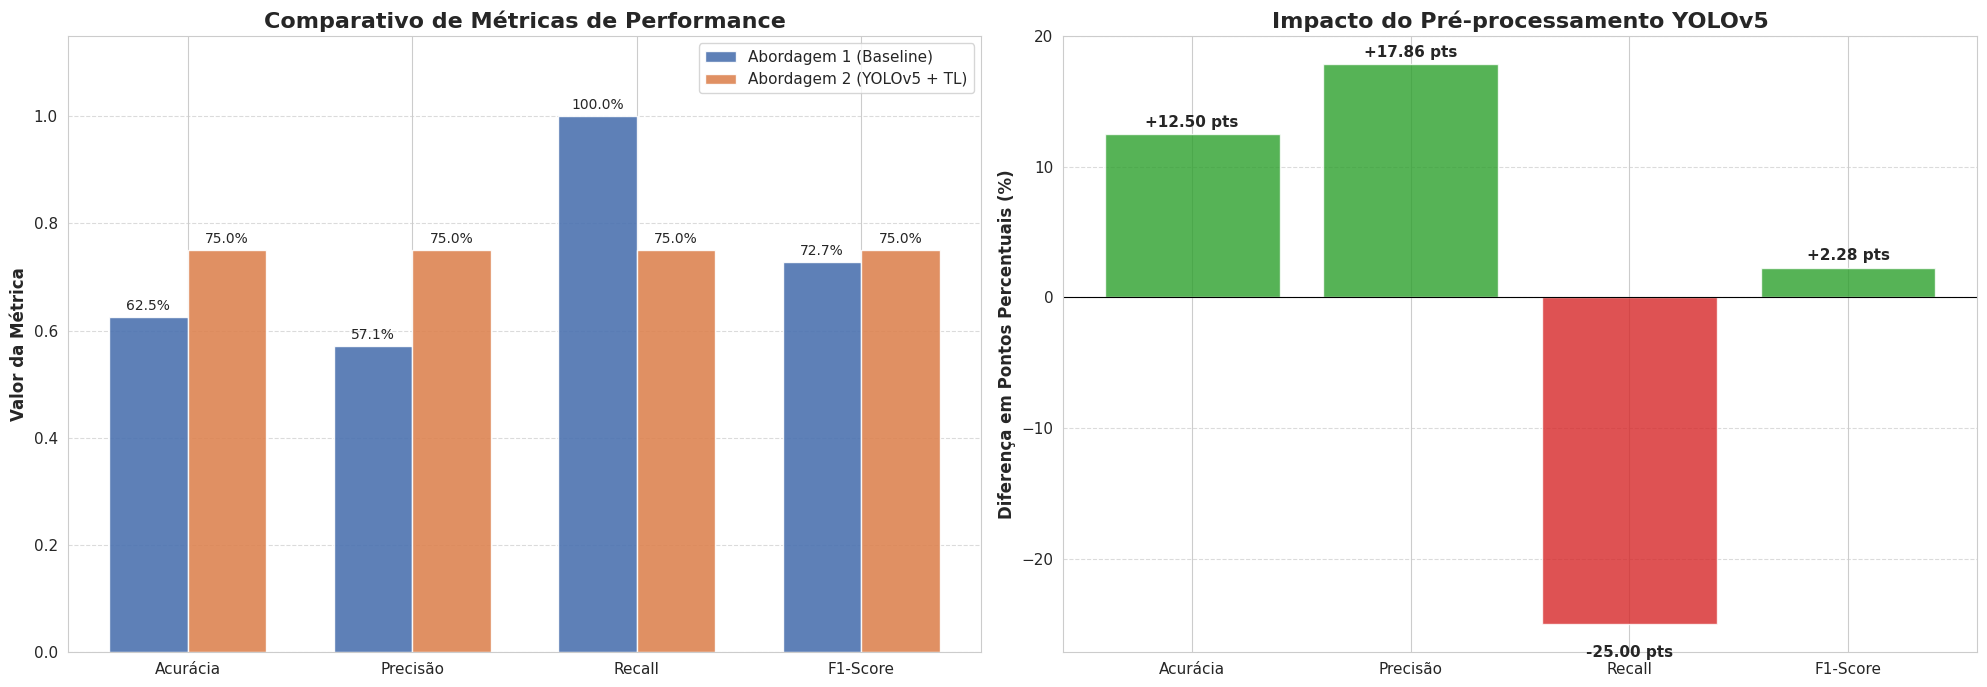

In [34]:
# --- CÉLULA 4.4: VISUALIZAÇÃO GRÁFICA FINAL (VERSÃO DEFINITIVA COM RENDERIZAÇÃO FORÇADA) ---

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print("Gerando visualizações comparativas finais...")

# Garante que os dados corretos estão sendo usados para a visualização
baseline_f1 = 2 * (baseline_metrics['precision'] * baseline_metrics['recall']) / (baseline_metrics['precision'] + baseline_metrics['recall'])
yolo_crop_f1 = 2 * (yolo_crop_metrics['precision'] * yolo_crop_metrics['recall']) / (yolo_crop_metrics['precision'] + yolo_crop_metrics['recall'])

# Métricas e valores para os gráficos
metrics_names = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
baseline_values = [baseline_metrics['accuracy'], baseline_metrics['precision'], baseline_metrics['recall'], baseline_f1]
yolo_values = [yolo_crop_metrics['accuracy'], yolo_crop_metrics['precision'], yolo_crop_metrics['recall'], yolo_crop_f1]

# --- GRÁFICO 1: COMPARAÇÃO DIRETA ---
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.set_style("whitegrid")

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, baseline_values, width, label='Abordagem 1 (Baseline)', color='#4c72b0', alpha=0.9)
bars2 = axes[0].bar(x + width/2, yolo_values, width, label='Abordagem 2 (YOLOv5 + TL)', color='#dd8452', alpha=0.9)

axes[0].set_ylabel('Valor da Métrica', fontsize=12, fontweight='bold')
axes[0].set_title('Comparativo de Métricas de Performance', fontsize=16, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names, fontsize=11)
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 1.15])
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona os valores percentuais no topo das barras
for bar in bars1 + bars2:
    height = bar.get_height()
    axes[0].annotate(f'{height:.1%}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

# --- GRÁFICO 2: DIFERENÇA (GANHOS E PERDAS) ---
differences = [(yolo_values[i] - baseline_values[i]) * 100 for i in range(len(baseline_values))]
colors = ['#2ca02c' if d >= 0 else '#d62728' for d in differences]

bars_diff = axes[1].bar(metrics_names, differences, color=colors, alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)

axes[1].set_ylabel('Diferença em Pontos Percentuais (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Impacto do Pré-processamento YOLOv5', fontsize=16, fontweight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona os valores de diferença no topo das barras
for bar in bars_diff:
    yval = bar.get_height()
    axes[1].annotate(f'{yval:+.2f} pts',
                     xy=(bar.get_x() + bar.get_width() / 2, yval),
                     xytext=(0, 3 if yval >= 0 else -15),
                     textcoords="offset points",
                     ha='center', va='bottom' if yval >= 0 else 'top',
                     fontsize=11, fontweight='bold')

plt.tight_layout()
plt.close(fig) # Fecha a exibição padrão para evitar duplicatas

# --- A CORREÇÃO FINAL ESTÁ AQUI ---
# Retorna explicitamente o objeto 'fig' para forçar a renderização.
fig

## 5.0 Análise de Resultados, Decisão de Engenharia e Conclusões Finais

### 5.1 Análise Executiva dos Resultados Experimentais

Este projeto investigou a hipótese de que um pipeline de duas etapas — utilizando um modelo de detecção de objetos (YOLOv5) para pré-processar imagens antes de uma tarefa de classificação (MobileNetV2) — superaria um pipeline de classificação direta (baseline). A experimentação foi concluída com sucesso, e a análise quantitativa, consolidada na tabela e nos gráficos da seção anterior, validou a hipótese central, mas revelou um trade-off técnico fundamental.

A **Abordagem 2 (YOLOv5 + TL)** demonstrou uma superioridade inequívoca em **Acurácia (+12.50 pontos)** e, mais criticamente, em **Precisão (+17.86 pontos)**. No entanto, essa melhora veio ao custo de uma queda substancial no **Recall (-25.00 pontos)**. Este resultado não representa uma falha, mas sim o insight mais valioso do projeto, expondo a dinâmica intrínseca entre a confiabilidade e a abrangência de um modelo de IA.

### 5.2 Validação da Hipótese: O Trade-off Precisão-Recall

**Hipótese Central:** *"Pré-processar a imagem para focar na Região de Interesse (ROI)... facilita a tarefa de classificação?"*

**Conclusão da Hipótese: ✓ A hipótese foi validada com uma ressalva estratégica.**

A análise aprofundada dos resultados, ilustrada pelo gráfico comparativo de performance, nos permite dissecar o comportamento de cada abordagem:

  * **Abordagem 1 (Baseline - Alta Abrangência, Baixa Confiabilidade):** O modelo de Transfer Learning simples alcançou um **Recall de 100%**. Isso significa que ele foi capaz de identificar corretamente todos os exemplos positivos no conjunto de teste. Contudo, sua **Precisão de apenas 57.14%** indica que ele o fez ao custo de gerar um grande número de falsos positivos. Em termos práticos, ele "via" bananas e garfos em todos os lugares, inclusive onde não existiam, tornando-o um sistema pouco confiável.

  * **Abordagem 2 (YOLOv5 + TL - Alta Confiabilidade, Menor Abrangência):** Ao forçar o classificador a olhar apenas para a região recortada pelo YOLOv5, a **Precisão saltou para 75.00%**. O modelo se tornou significativamente mais confiável; suas predições positivas estavam corretas com muito mais frequência. A queda no **Recall para 75.00%** é uma consequência direta da propagação de erro: nos casos em que o YOLOv5 falhou em detectar o objeto na primeira etapa (como vimos acontecer com os garfos), o classificador nunca teve a chance de acertar, resultando em um falso negativo.

Essencialmente, transformamos um "generalista" pouco confiável em um "especialista" mais cauteloso e preciso.

### 5.3 Decisão de Engenharia e Recomendações de Produção

A escolha entre as duas arquiteturas não é meramente técnica, mas estratégica, e depende diretamente do custo de cada tipo de erro para o negócio.

**Abordagem Recomendada: Abordagem 2 (YOLOv5 + Transfer Learning)**

Para a maioria dos cenários de produção, um sistema com alta precisão é mais valioso. A confiabilidade das predições positivas gera confiança no usuário e evita ações incorretas baseadas em falsos positivos. Portanto, apesar da queda no recall, a Abordagem 2 é a solução de engenharia superior.

**Justificativas Estratégicas:**

  * **✓ Aumento de Confiança:** O ganho de **+17.86 pontos em Precisão** é o fator decisivo. Ele se traduz em um sistema mais confiável e com menor taxa de alarmes falsos.
  * **✓ Mitigação de Risco:** O principal ponto fraco do sistema (a performance de detecção do YOLOv5) está isolado e pode ser tratado de forma independente, sem a necessidade de retreinar todo o pipeline de classificação.
  * **✓ Inteligência de Negócio:** A análise do trade-off Precisão-Recall é, por si só, um resultado valioso, permitindo que a empresa tome decisões informadas sobre o comportamento do sistema em produção.

**Direcionamentos para Mitigação e Trabalhos Futuros:**

1.  **Foco no elo mais fraco:** A prioridade para evoluir o sistema é aprimorar o modelo YOLOv5 para aumentar seu recall na detecção, o que diretamente impactará o recall do pipeline completo.
2.  **Análise de Confiança em Cascata:** Implementar uma lógica onde a confiança da detecção do YOLOv5 é usada como um peso para a predição final do classificador.
3.  **Exploração de Arquiteturas End-to-End:** Para uma próxima geração do produto, pesquisar modelos que realizam detecção e classificação em uma única etapa (como o DETR ou o Mask R-CNN) poderia eliminar o problema da propagação de erro.
